Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_examples = 100
    score_name = "quality"
    clean_up = False
    show_console = False

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_list_src,
    define_Stan_inspection_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_inspection_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_train_examples: int = m_examples
m_test_examples: int = m_examples
noise_scale = 0.87
continue_inspection_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_inspection_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
stan_model_inspection_src = define_Stan_inspection_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_inspection_src)
data_inspection_str = format_Stan_inspection_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=continue_inspection_probability,
)
fit_inspection = run_stan_model(
    stan_model_src=stan_model_inspection_src,
    data_str=data_inspection_str,
    model_note='inspection_model',
    clean_up=clean_up,
    show_console=show_console,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of inspecting on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of

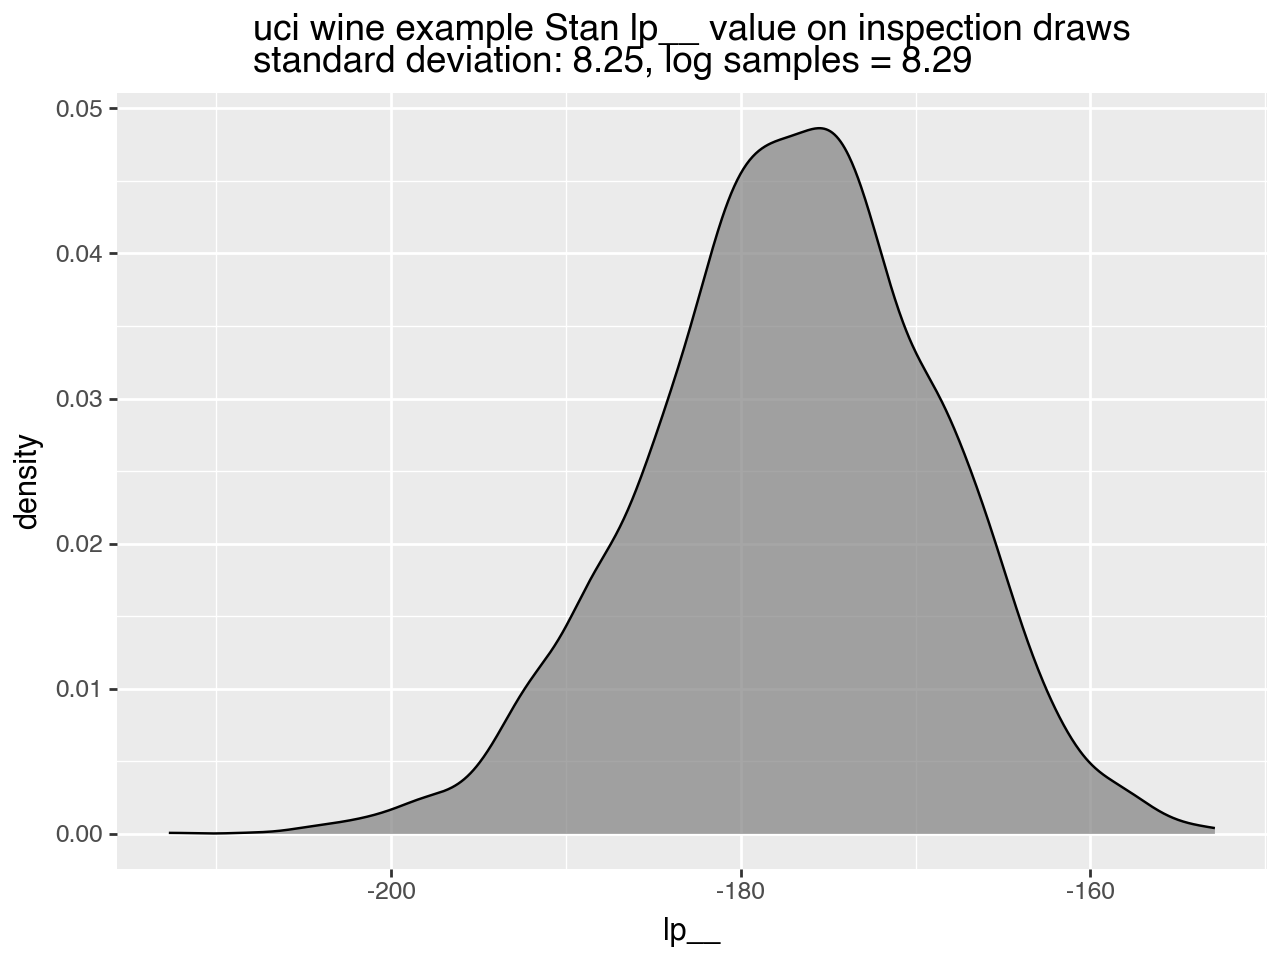

In [21]:
# get implied sample weights from chain
wt_frame_inspection = fit_inspection.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_inspection["lp__"]))
    log_samples = np.log(wt_frame_inspection.shape[0])
    (
        ggplot(
            data=wt_frame_inspection,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on inspection draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [22]:
beta_draws = fit_inspection.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,0.198799,-11.93620,1.83610,-0.886321,-2.71142,0.890195,-0.436121,-2.090290,6.486010,-17.00360,...,-10.59780,1.087560,-3.727580,-0.150004,0.008622,-0.941489,3.394710,3.625710,1.90900,-22.689700
1,1.633300,4.52007,-2.04459,-1.685380,7.03196,0.596180,-0.411184,8.642800,5.387600,16.32820,...,-7.96974,0.863638,2.706470,-0.048498,-0.053915,-1.489390,10.806600,7.467070,5.22007,22.437200
2,-0.239890,-9.83994,3.16119,2.073200,-2.77959,0.887940,-0.596851,-0.230328,5.510280,-18.02280,...,11.79040,0.814144,-8.293860,-0.103046,-0.027759,2.083700,-13.053300,-6.723530,2.47406,0.010417
3,-0.247154,-2.93197,8.81771,-1.233570,1.33658,0.674481,-0.483503,7.989910,5.002850,17.73390,...,-16.01670,0.782775,7.719490,-0.140082,0.011373,-2.228600,3.956620,13.871600,2.90952,-2.926220
4,-0.428780,-5.14373,10.59760,-1.025040,3.29876,0.834939,-0.546437,10.424200,7.028310,13.42820,...,-17.58140,0.802445,10.566600,-0.067211,0.016831,-2.885960,2.740670,15.518400,2.79298,-7.102260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.189100,-14.27510,-5.56131,-1.430100,-25.33250,1.435470,-0.742334,-0.102477,0.472025,-4.67321,...,10.70830,0.978768,0.440158,-0.162581,-0.019762,-4.698620,-5.642110,19.367700,2.11617,9.941420
3996,-0.129442,11.90570,4.84356,-0.608771,14.06520,1.562310,-0.906161,8.205590,12.368000,-3.11585,...,-9.61124,0.671484,4.068750,-0.228381,0.077013,-7.563450,8.240840,0.381051,5.83456,-11.480500
3997,1.170230,-18.87850,-5.20956,-0.441035,-17.52550,1.542630,-1.337950,-6.573370,-0.233818,-2.61538,...,4.13373,1.118780,-4.119980,-0.109689,-0.097616,7.651660,-1.514590,7.262360,3.11064,6.634800
3998,1.138800,-2.87108,9.61076,0.898955,10.58200,0.380831,-0.297692,8.725280,16.066800,6.30529,...,-1.06128,0.292559,4.020980,-0.141020,0.016030,-8.453410,-0.036612,7.489980,2.10071,-3.692040


In [23]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_inspection_Stan = beta_draws_display.loc[
    wt_frame_inspection["lp__"] >= np.quantile(wt_frame_inspection["lp__"], 0.5), :
].mean()
estimated_beta_inspection_Stan

fixed acidity is red             0.421632
volatile acidity is red         -3.696789
citric acid is red               0.415247
residual sugar is red            0.102771
chlorides is red                -1.702675
free sulfur dioxide is red       0.616599
total sulfur dioxide is red     -0.515914
density is red                   0.982925
pH is red                        5.691306
sulphates is red                -2.510669
alcohol is red                   1.008565
fixed acidity is white          -1.677126
volatile acidity is white       -8.754229
citric acid is white            -0.430811
residual sugar is white          0.762700
chlorides is white               0.427419
free sulfur dioxide is white    -0.093908
total sulfur dioxide is white   -0.015113
density is white                -0.551391
pH is white                      1.496781
sulphates is white               6.685887
alcohol is white                 2.960303
is_red                           0.813359
dtype: float64

In [24]:
estimated_beta_inspection_Stan = list(estimated_beta_inspection_Stan) + [0] * n_alternatives  # TODO: clean

picks


/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,row,position,pick probability estimate,was pick
0,0,0,0.3643,False
1,0,1,0.1633,False
2,0,2,0.1876,True
3,0,3,0.0940,False
4,0,4,0.1908,False
5,1,0,0.0977,False
6,1,1,0.3225,True
7,1,2,0.3013,False
8,1,3,0.1678,False
9,1,4,0.1107,False


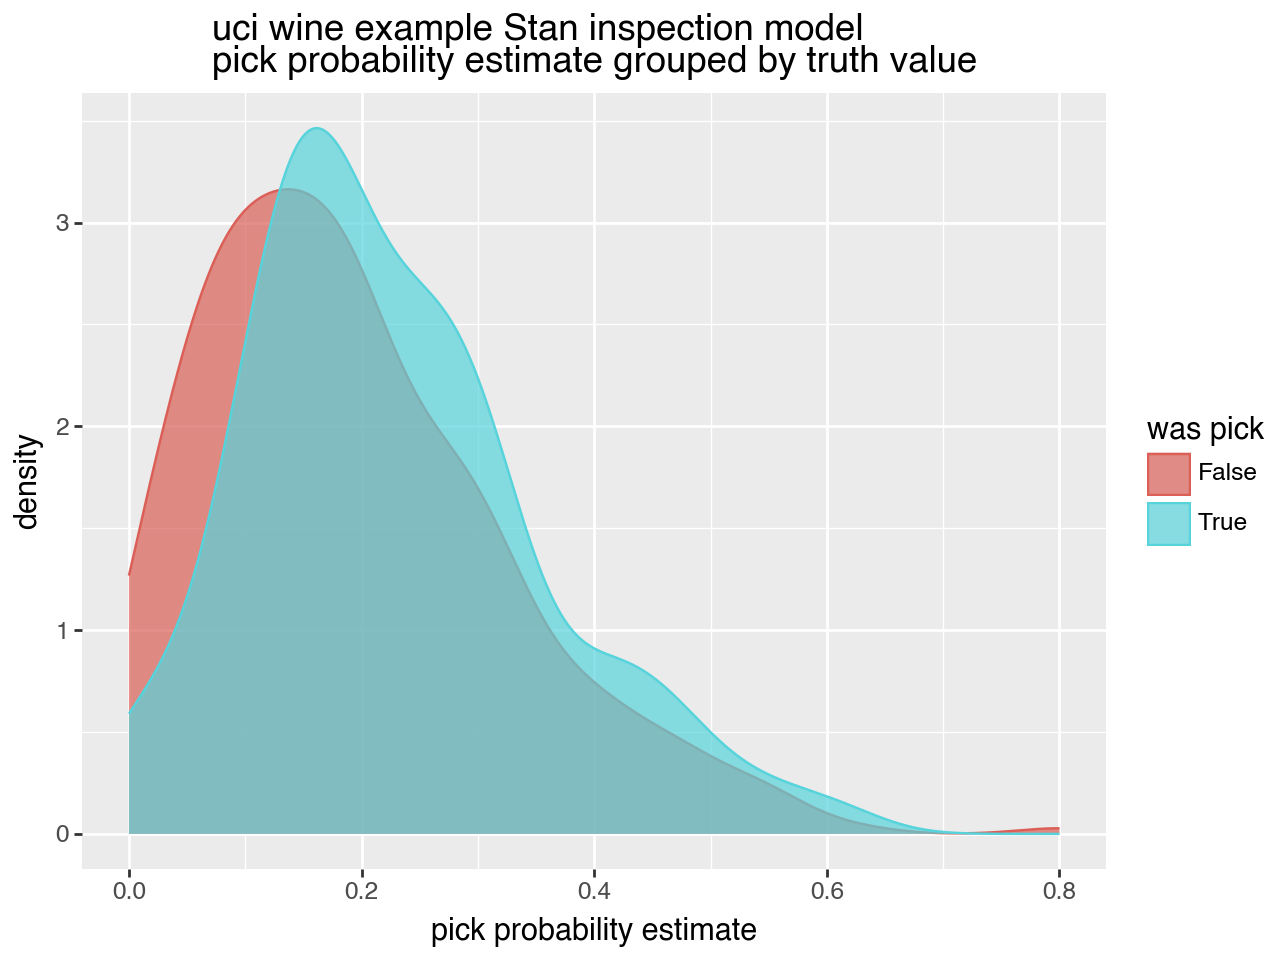

<Figure size 640x480 with 0 Axes>

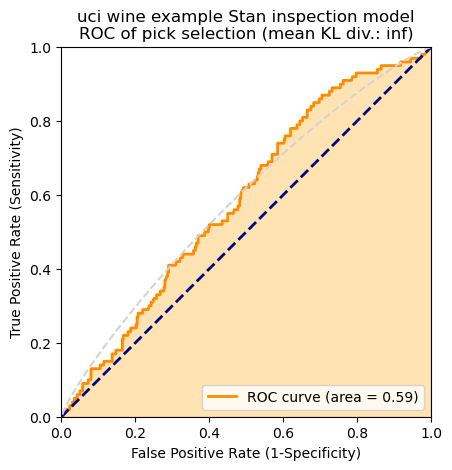

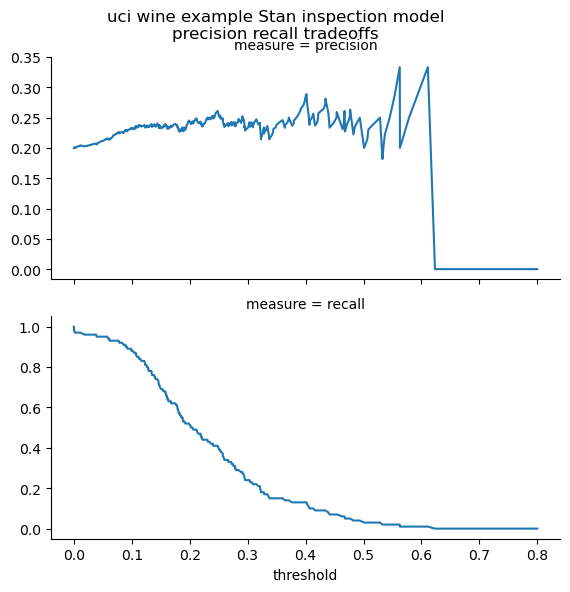

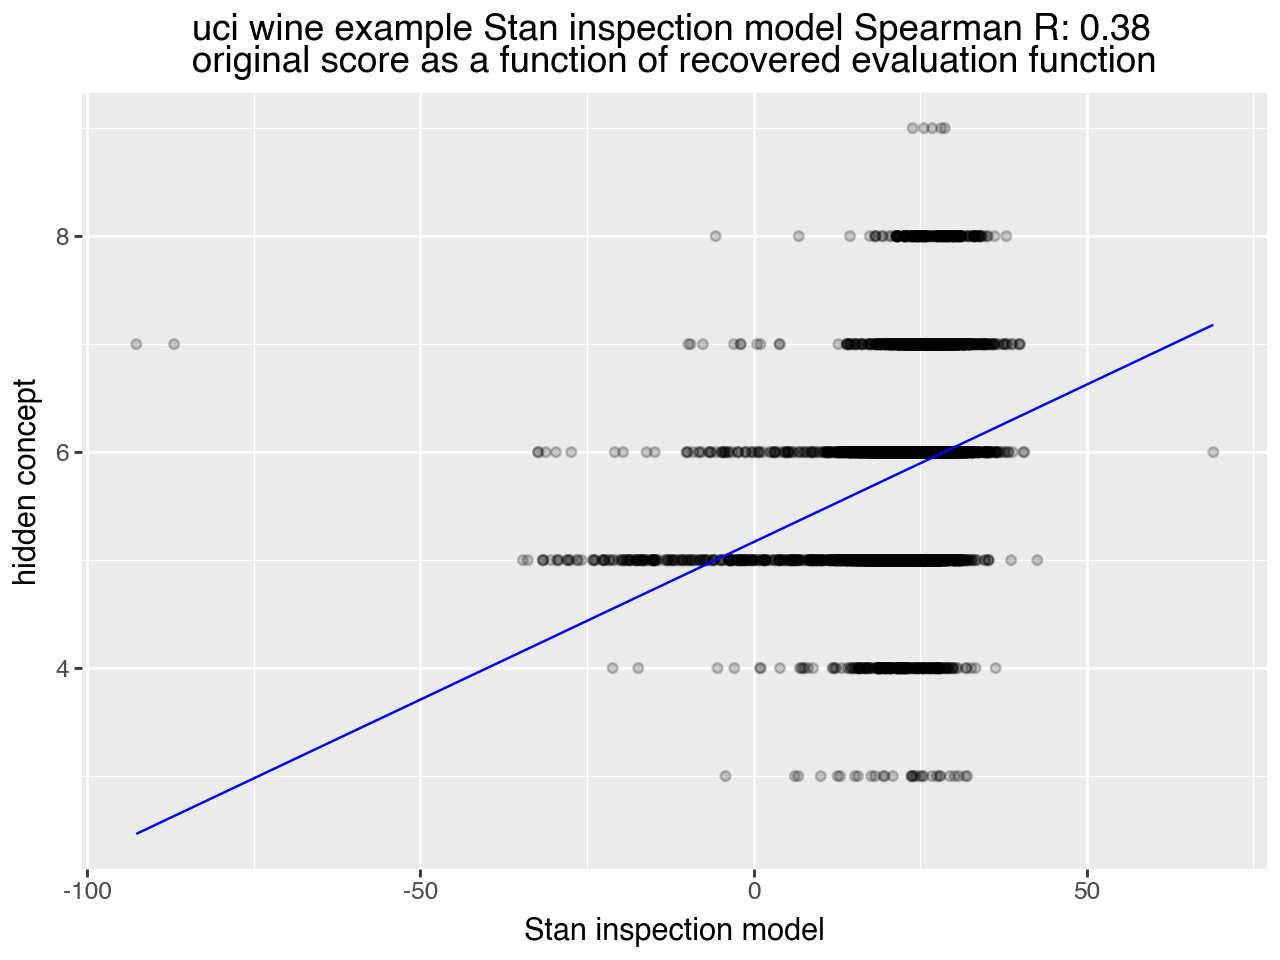

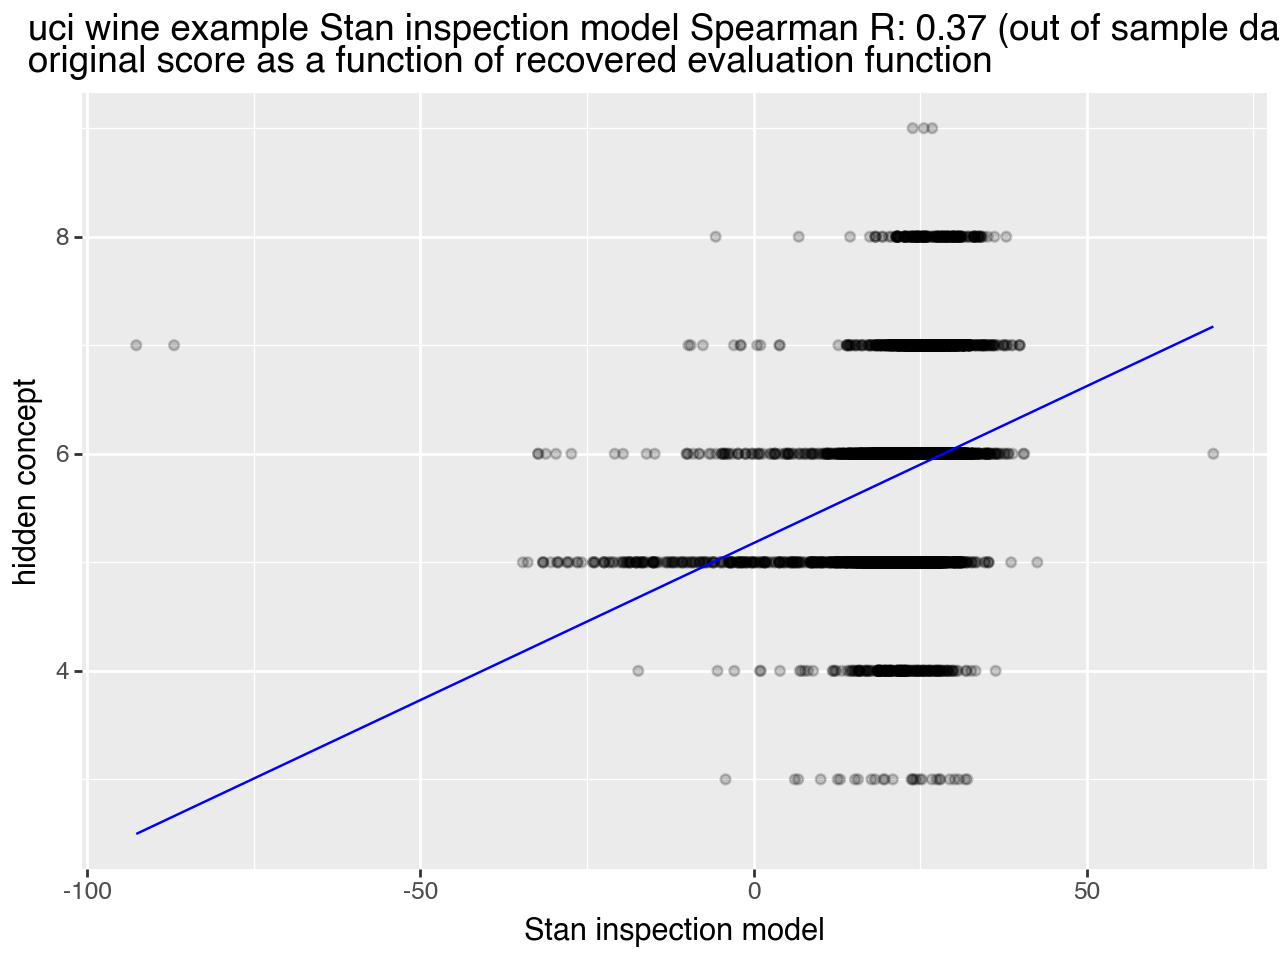

In [25]:
stat_pull_inspection_Stan = plot_rank_performance(
    model=estimated_beta_inspection_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of lists
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan inspection model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_inspection_Stan)

Try a Stan model with position choice modeled as utility.

In [26]:
observations_sorted_train = sort_observations_frame(observations_train)

In [27]:
stan_model_list_src = define_Stan_list_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_list_src)
data_str = format_Stan_data(
    observations_sorted=observations_sorted_train,
    features_frame=features_frame,
)
fit_utility_Stan = run_stan_model(
    stan_model_src=stan_model_list_src,
    data_str=data_str,
    model_note='utility_model',
    clean_up=clean_up,
    show_console=show_console,
)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [28]:
beta_draws_utility = fit_utility_Stan.draws_pd(vars=["beta"])
beta_draws_utility_display = beta_draws_utility.copy()
beta_draws_utility_display.columns = list(features_frame.columns) + [
    f'position_{sel_j}' for sel_j in range(n_alternatives)
]

beta_draws_utility_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_0,position_1,position_2,position_3,position_4
0,2.323460,-7.16487,-3.99655,-1.894030,-14.17230,0.190903,-0.139643,-2.12901,13.177100,-17.856700,...,-7.367570,4.651370,1.350570,3.34272,-12.60780,5.227690,-4.470370,-6.44061,-8.82090,-11.26220
1,2.275600,-4.32658,-1.26285,-1.360600,-4.32878,0.511811,-0.377021,6.76958,9.515870,0.574902,...,3.723720,2.669540,7.090250,2.79113,2.01974,2.517780,-2.247970,-7.22730,-13.29140,-14.17300
2,0.505376,13.30570,8.85517,-2.049120,10.46120,0.330931,-0.179686,2.15277,10.029900,20.012600,...,7.479420,6.096960,11.121000,3.16113,8.56750,4.730850,0.790559,-1.64392,-8.31055,-5.43192
3,1.255030,-14.22010,-10.12670,-1.306390,-8.01262,-0.003533,-0.153712,2.56324,-0.820041,-30.894100,...,-9.871000,-6.822100,0.593939,3.19954,-7.24456,5.096250,-1.065160,-6.33757,-6.13868,-12.84410
4,0.372385,-11.43700,2.83197,-1.749160,-18.48080,0.066968,0.087478,-5.76628,7.346060,-16.437100,...,-1.796830,0.476170,4.581690,2.09572,-5.55858,6.064300,0.240355,-2.56223,-8.70173,-11.94690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.826080,-6.68524,-7.59474,-1.749630,2.94306,-0.213172,-0.067919,9.16102,4.632700,1.159500,...,6.105510,-2.726050,12.586100,1.91139,-4.40552,1.376890,-6.785030,-6.77489,-10.60380,-15.68630
3996,1.891930,3.45627,-7.38637,-1.388890,3.47012,-0.032330,-0.131782,4.13864,10.223100,3.542100,...,13.800900,0.546881,11.454800,1.82766,-5.86357,-1.703340,-4.154240,-7.55979,-10.04740,-16.63990
3997,1.633920,-1.29561,-5.10081,0.738437,10.71920,0.435364,-0.281359,4.63043,10.323400,2.152990,...,0.197785,-3.655090,13.725300,3.03641,-0.31187,0.407342,-2.637850,-3.27608,-11.53650,-10.18250
3998,1.673430,-2.37078,-4.11918,0.996553,11.24550,0.463127,-0.277907,5.41806,11.055700,1.174910,...,-0.873065,-2.512510,13.771300,2.98626,1.78948,0.771613,-2.702570,-3.87017,-10.27860,-9.52899


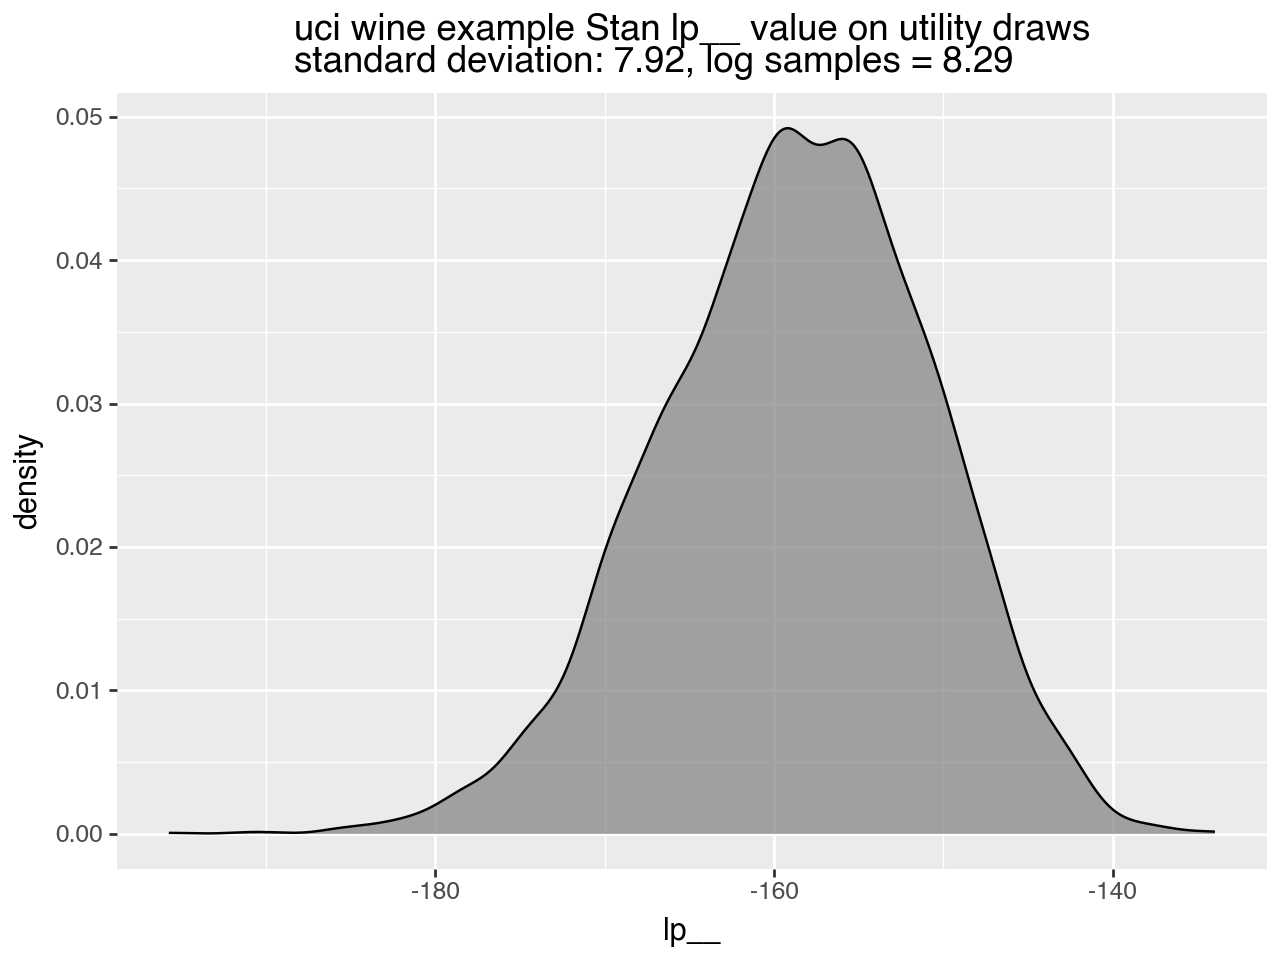

In [29]:
# get implied sample weights from chain
wt_frame_utility = fit_utility_Stan.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_utility["lp__"]))
    log_samples = np.log(wt_frame_utility.shape[0])
    (
        ggplot(
            data=wt_frame_utility,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on utility draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [30]:
estimated_beta_utility_Stan = beta_draws_utility_display.loc[
    wt_frame_utility["lp__"] >= np.quantile(wt_frame_utility["lp__"], 0.5), :
].mean()
estimated_beta_utility_Stan

fixed acidity is red             0.260252
volatile acidity is red         -4.370592
citric acid is red               2.788601
residual sugar is red           -0.924778
chlorides is red                -1.614768
free sulfur dioxide is red       0.254554
total sulfur dioxide is red     -0.167956
density is red                   1.077663
pH is red                        4.773198
sulphates is red                -5.163575
alcohol is red                   0.771224
fixed acidity is white          -1.318824
volatile acidity is white       -9.387604
citric acid is white            -2.665295
residual sugar is white          0.548079
chlorides is white               0.222909
free sulfur dioxide is white    -0.043577
total sulfur dioxide is white   -0.001340
density is white                -1.499689
pH is white                      0.813527
sulphates is white               5.482212
alcohol is white                 2.406290
is_red                           0.998369
position_0                       8

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6069,False
1,0,1,0.1786,False
2,0,2,0.1442,True
3,0,3,0.0352,False
4,0,4,0.0351,False
5,1,0,0.3287,False
6,1,1,0.3645,True
7,1,2,0.2086,False
8,1,3,0.0651,False
9,1,4,0.0331,False


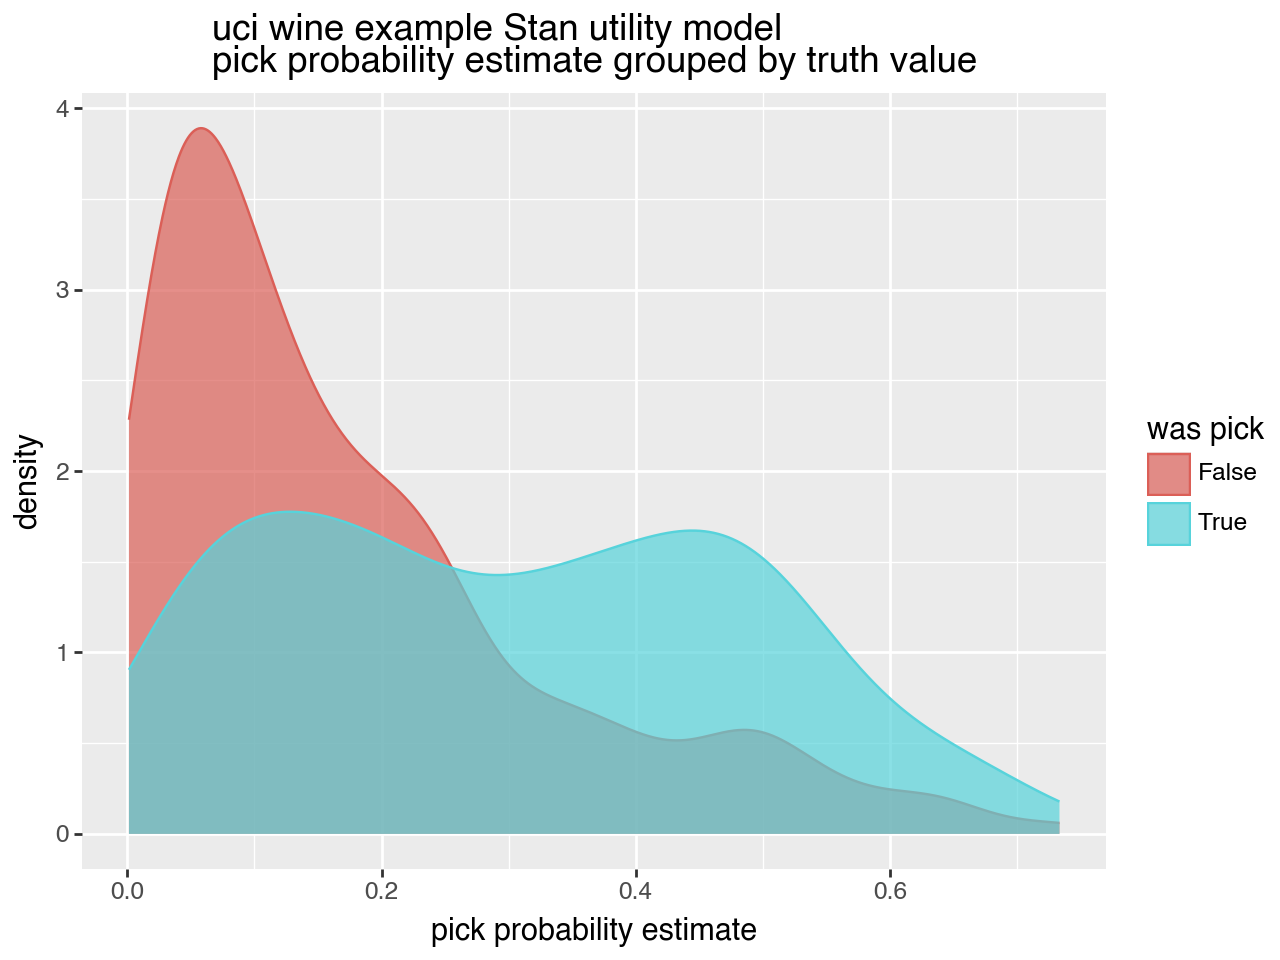

<Figure size 640x480 with 0 Axes>

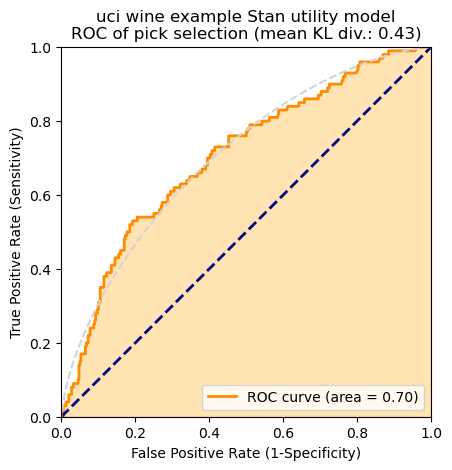

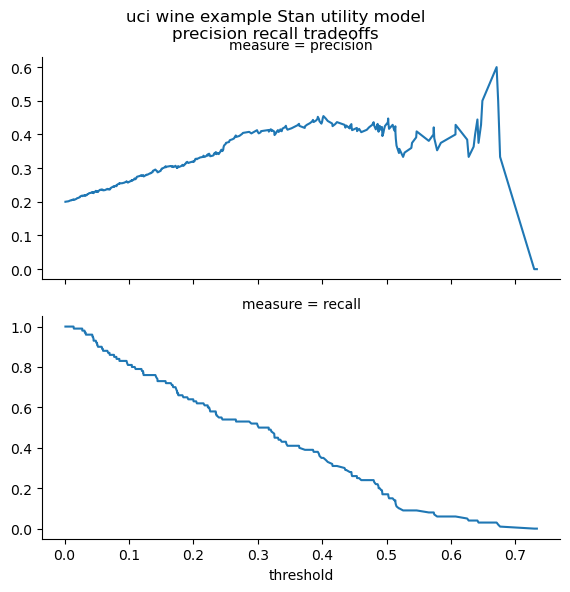

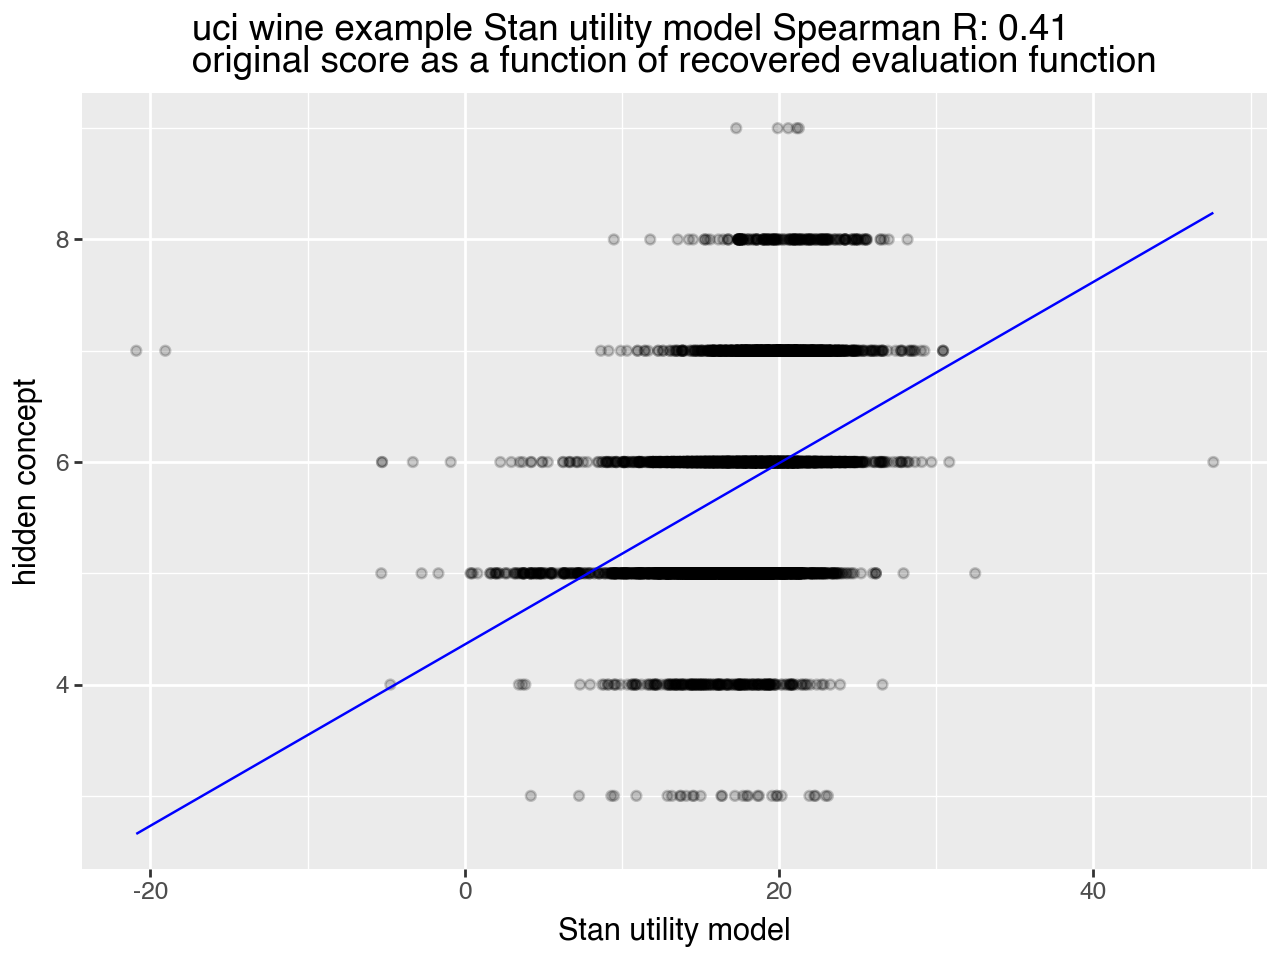

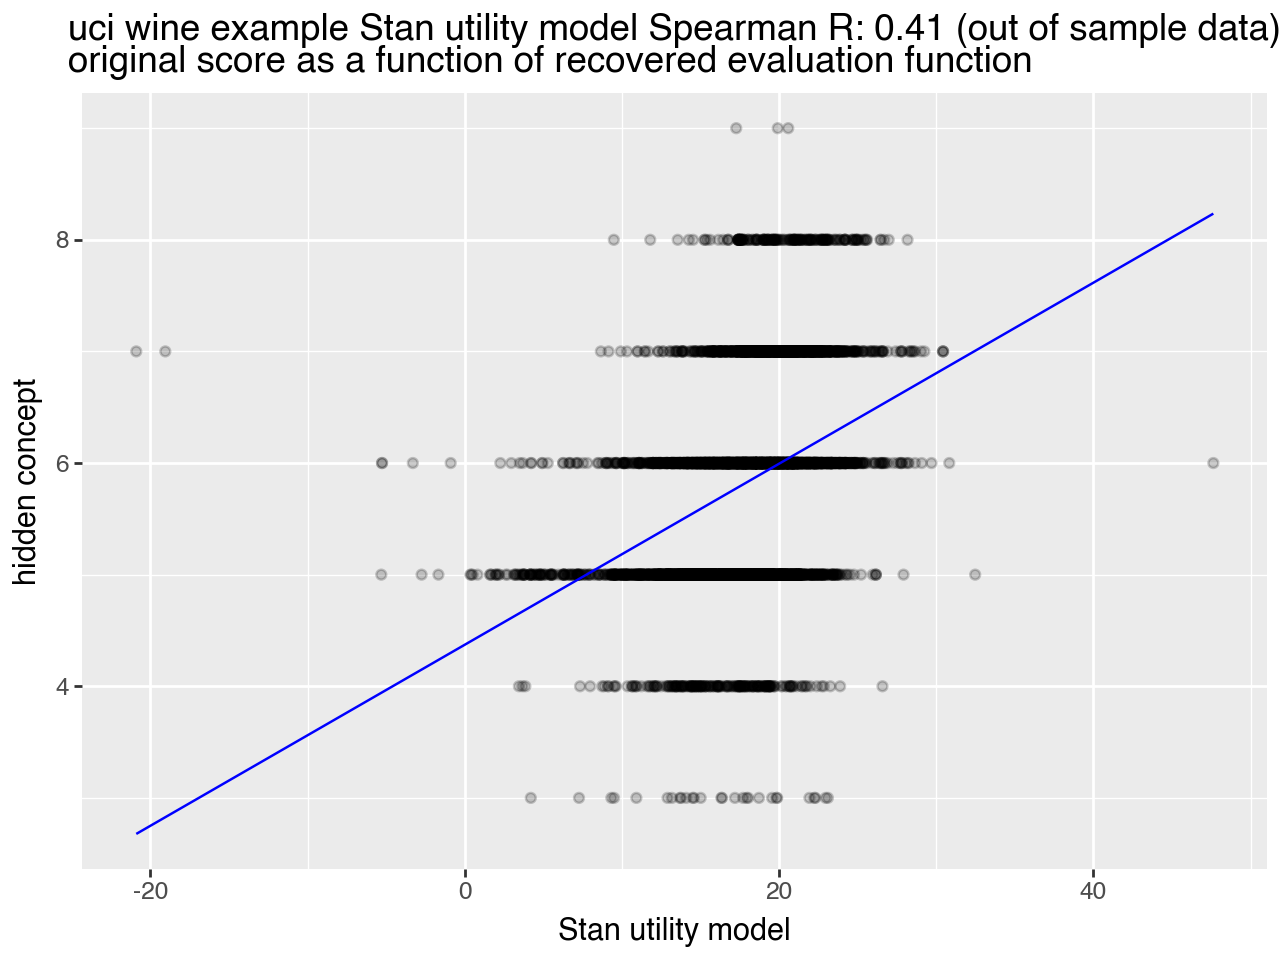

In [31]:
stat_pull_Stan = plot_rank_performance(
    model=estimated_beta_utility_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of lists
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan utility model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_Stan)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of list entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [33]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [34]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2451,False
1,0,1,0.2146,False
2,0,2,0.2043,True
3,0,3,0.1709,False
4,0,4,0.1651,False
5,1,0,0.2227,False
6,1,1,0.2332,True
7,1,2,0.2033,False
8,1,3,0.1762,False
9,1,4,0.1646,False


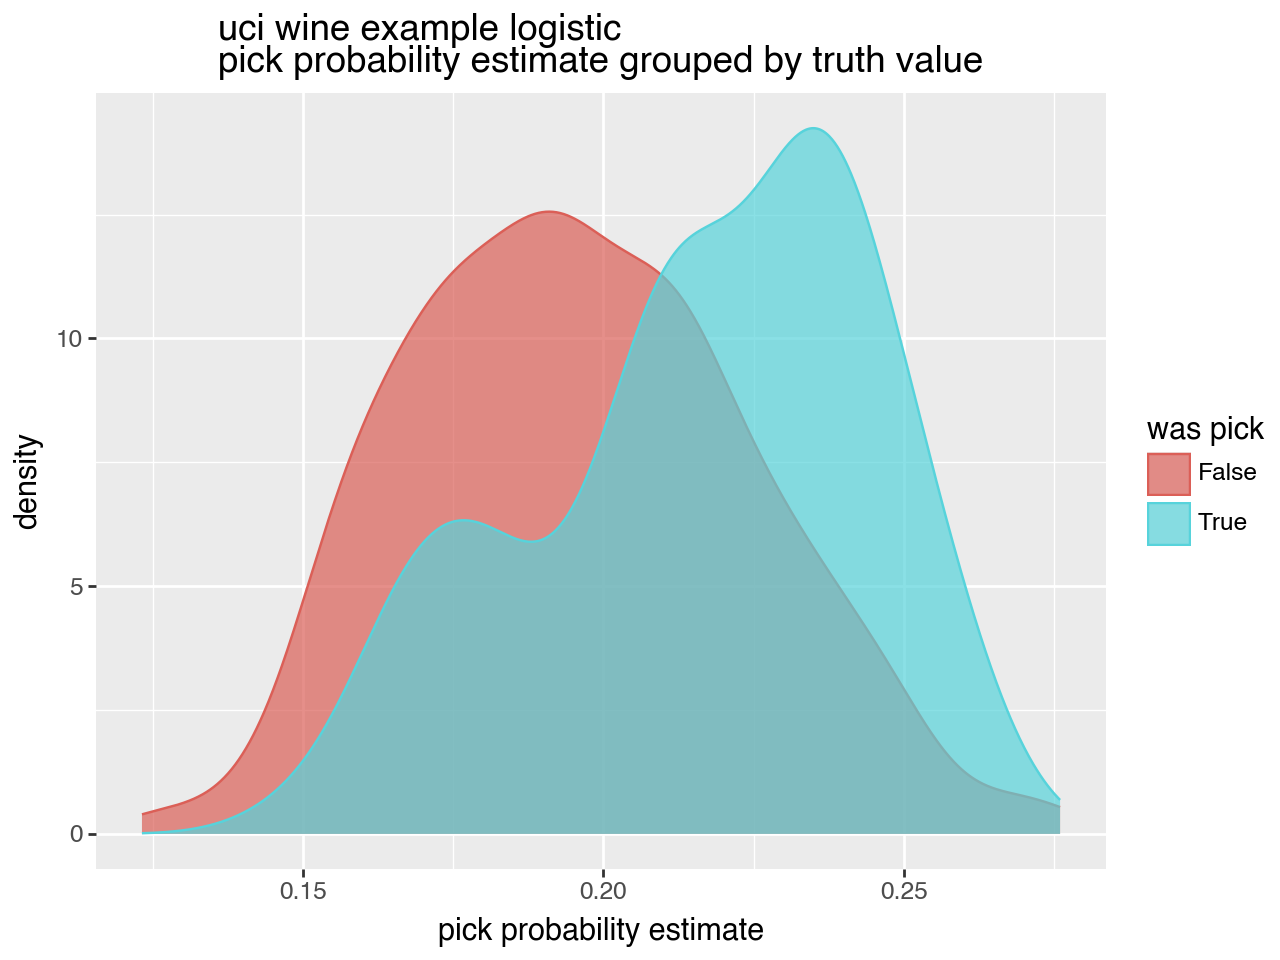

<Figure size 640x480 with 0 Axes>

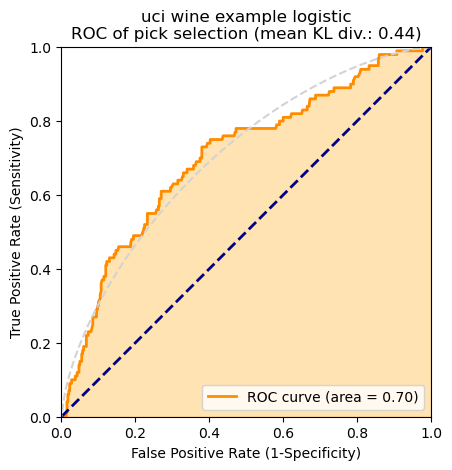

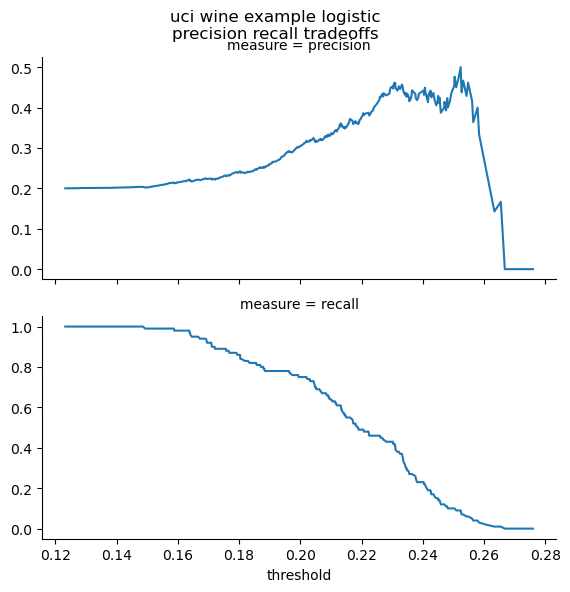

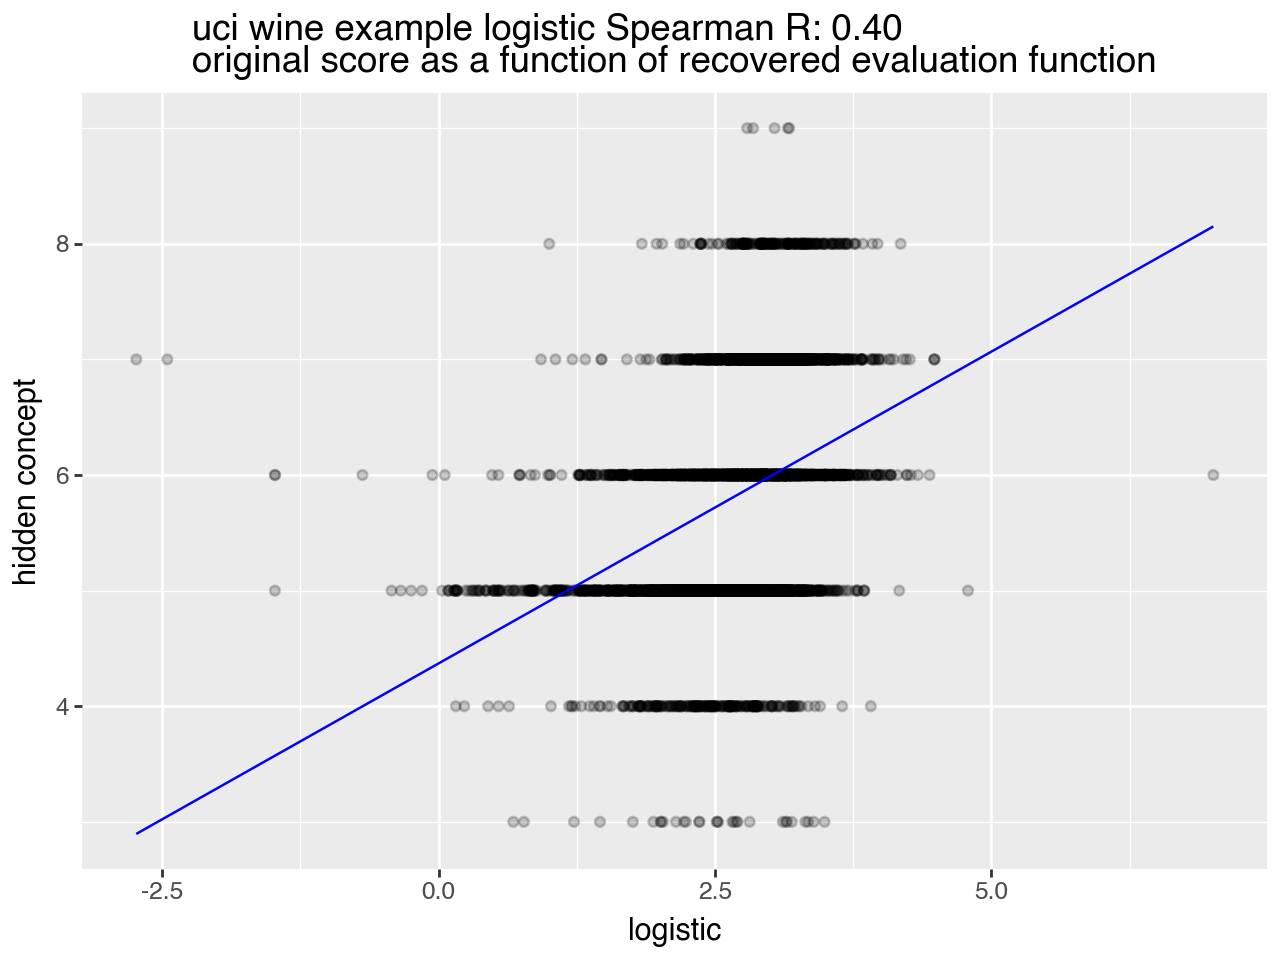

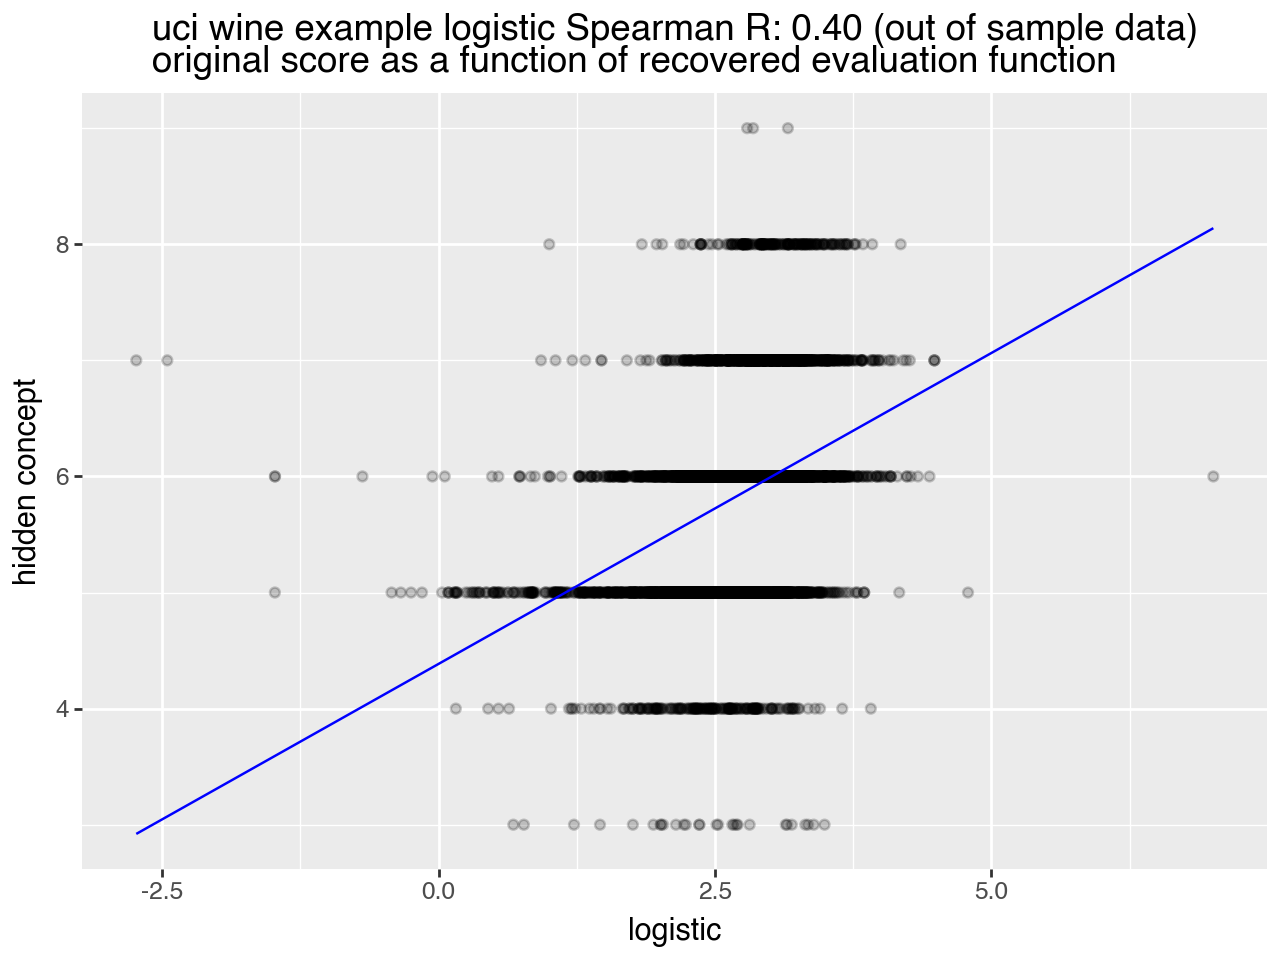

In [35]:
stat_pull_classifier = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of lists
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_classifier)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2107,False
1,0,1,0.1969,False
2,0,2,0.2126,True
3,0,3,0.1951,False
4,0,4,0.1847,False
5,1,0,0.1908,False
6,1,1,0.2103,True
7,1,2,0.2092,False
8,1,3,0.1998,False
9,1,4,0.1899,False


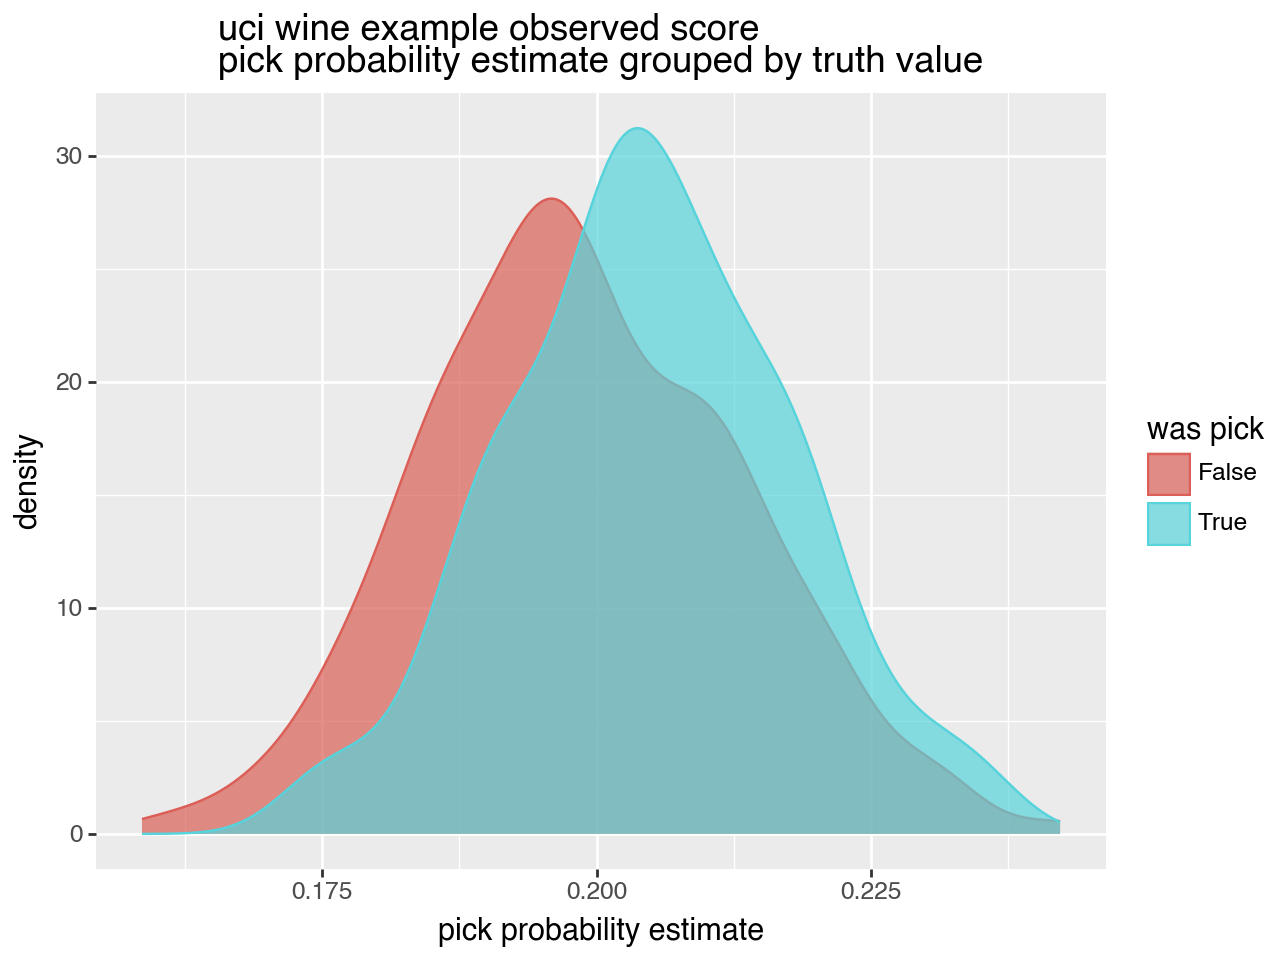

<Figure size 640x480 with 0 Axes>

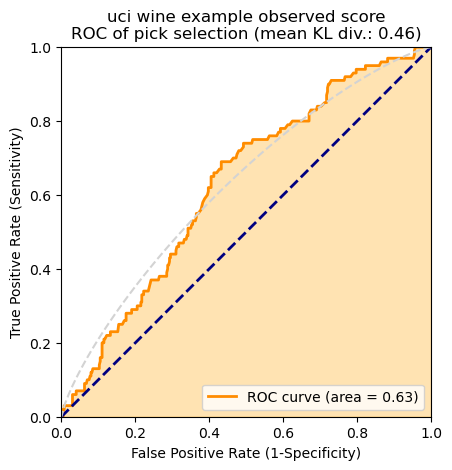

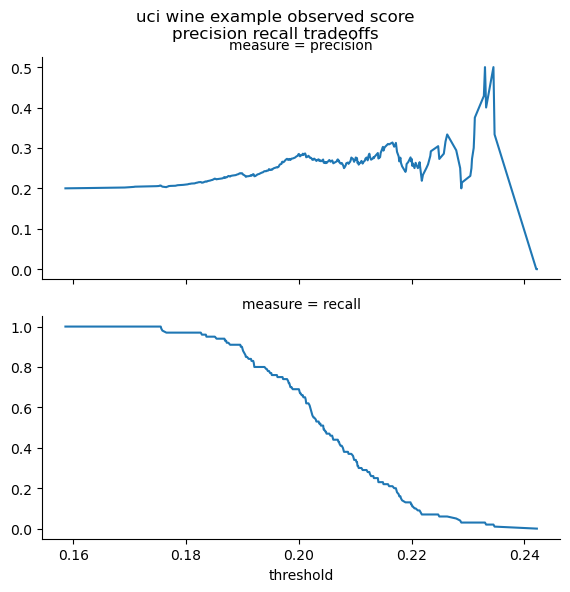

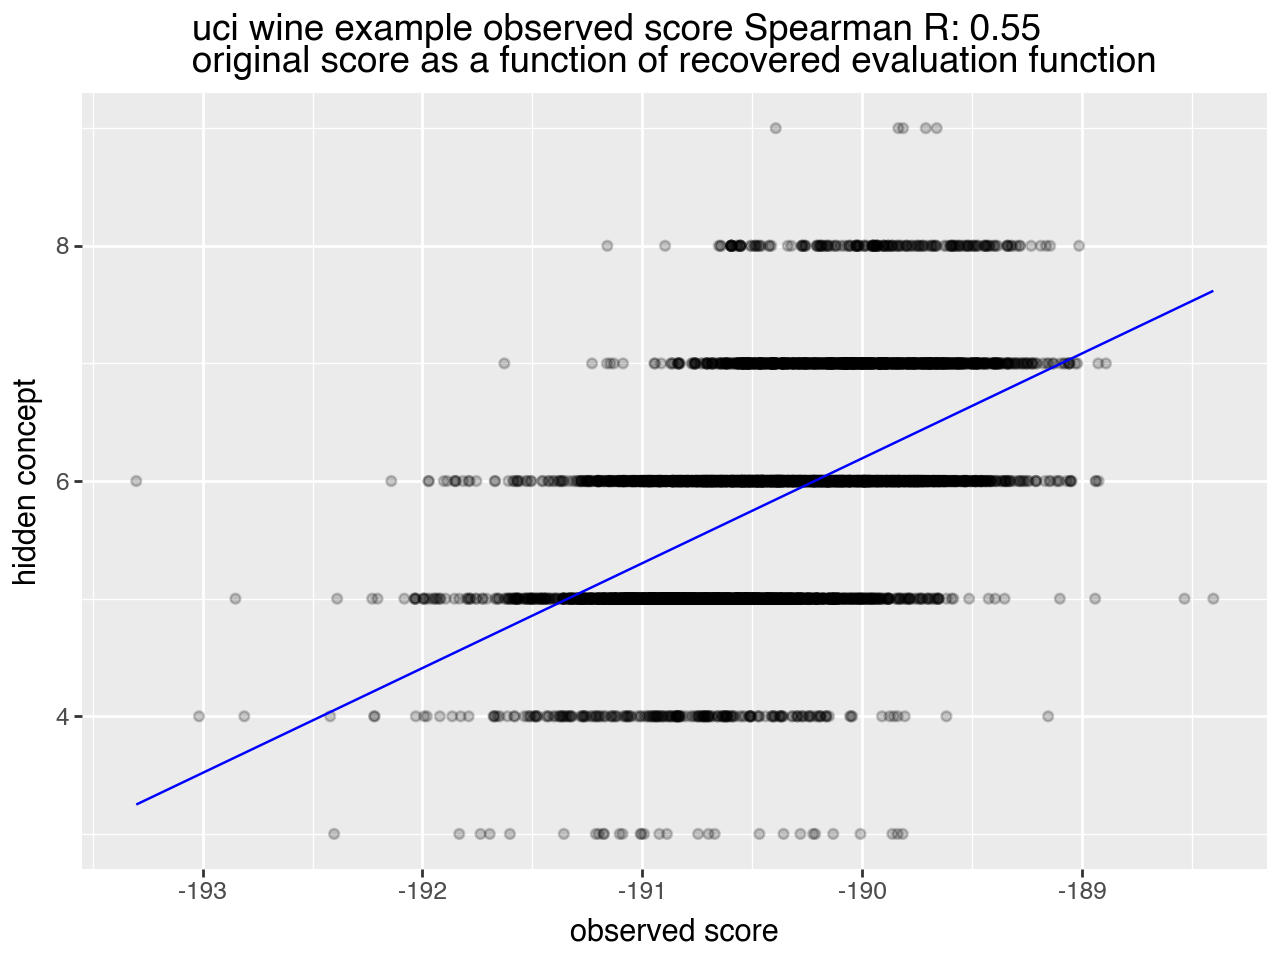

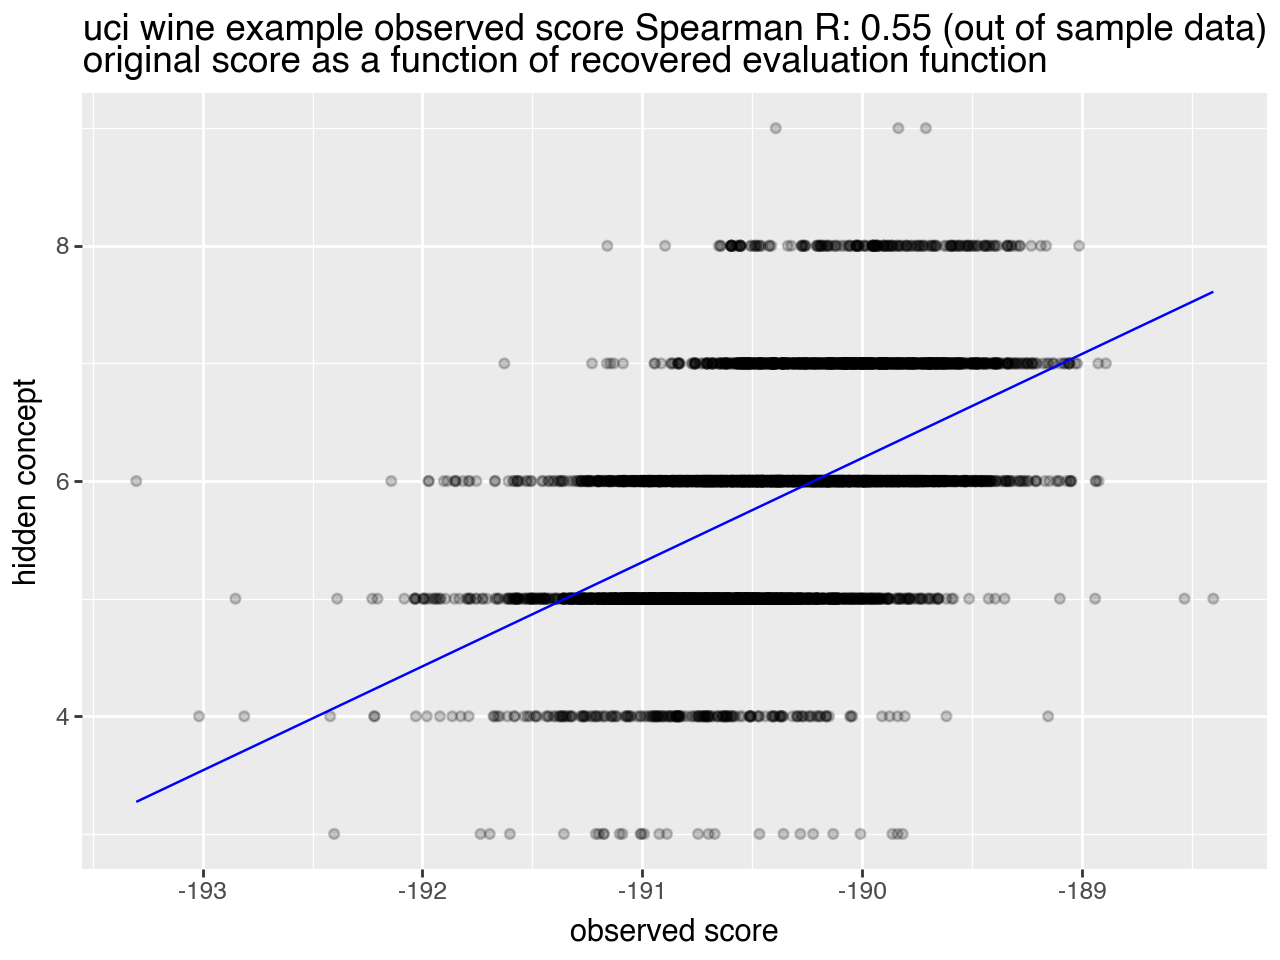

In [36]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [37]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [38]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [39]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training lists,test lists,data_size,test_size
0,uci wine example,Stan inspection model,0.375024,0.374134,0.585562,inf,100,100,6497,6013
1,uci wine example,Stan utility model,0.408415,0.407338,0.703400,0.428777,100,100,6497,6013
2,uci wine example,logistic,0.401345,0.399807,0.702450,0.444034,100,100,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.627475,0.458029,100,100,6497,6013
